In [1]:
%load_ext watermark
%watermark

%load_ext autoreload
%autoreload 2 


# import standard libs
from IPython.display import display
from IPython.core.debugger import set_trace as bp
from pathlib import PurePath, Path
import sys
import time
from collections import OrderedDict as od
import re
import os
import json
os.environ['THEANO_FLAGS'] = 'device=cpu,floatX=float32'

# import python scientific stack
import pandas as pd
import pandas_datareader.data as web
pd.set_option('display.max_rows', 100)
from dask import dataframe as dd
from dask.diagnostics import ProgressBar
pbar = ProgressBar()
pbar.register()
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from numba import jit
import math
import pymc3 as pm
from theano import shared, theano as tt

# import visual tools
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import seaborn as sns

plt.style.use('seaborn-talk')
plt.style.use('bmh')

#plt.rcParams['font.family'] = 'DejaVu Sans Mono'
#plt.rcParams['font.size'] = 9.5
plt.rcParams['font.weight'] = 'medium'
#plt.rcParams['figure.figsize'] = 10,7
blue, green, red, purple, gold, teal = sns.color_palette('colorblind', 6)

# import util libs
import pyarrow as pa
import pyarrow.parquet as pq
from tqdm import tqdm, tqdm_notebook
import warnings
warnings.filterwarnings("ignore")
import missingno as msno

from src.utils.utils import *
from src.features.bars import get_imbalance
import src.features.bars as brs
import src.features.snippets as snp

RANDOM_STATE = 777


print()
%watermark -p pandas,pandas_datareader,dask,numpy,pymc3,theano,sklearn,statsmodels,scipy,matplotlib,seaborn,pyarrow,fastparquet


2019-01-16T21:30:58+05:00

CPython 3.7.1
IPython 7.2.0

compiler   : Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 15.6.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit

pandas 0.23.4
pandas_datareader 0.7.0
dask 1.0.0
numpy 1.15.4
pymc3 3.6
theano 1.0.3
sklearn 0.20.1
statsmodels 0.9.0
scipy 1.1.0
matplotlib 3.0.2
seaborn 0.9.0
pyarrow 0.11.1
fastparquet not installed


In [2]:
def read_kibot_ticks(fp):
    # read tick data from http://www.kibot.com/support.aspx#data_format
    cols = list(map(str.lower,['Date','Time','Price','Bid','Ask','Size']))
    df = (pd.read_csv(fp, header=None)
          .rename(columns=dict(zip(range(len(cols)),cols)))
          .assign(dates=lambda df: (pd.to_datetime(df['date']+df['time'],
                                                  format='%m/%d/%Y%H:%M:%S')))
          .assign(v=lambda df: df['size']) # volume
          .assign(dv=lambda df: df['price']*df['size']) # dollar volume
          .drop(['date','time'],axis=1)
          .set_index('dates')
          .drop_duplicates())
    return df
    
infp = PurePath('data//raw//IVE_tickbidask.txt')

df = read_kibot_ticks(infp)
cprint(df)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                      price     bid     ask   size      v          dv
dates                                                                
2019-01-11 15:59:58  104.84  104.83  104.85    130    130    13629.20
2019-01-11 16:00:00  104.84  104.83  104.84  11407  11407  1195909.88
2019-01-11 16:10:00  104.84  104.78  105.04      0      0        0.00
2019-01-11 18:30:00  104.84  104.24  105.17      0      0        0.00
2019-01-11 20:00:00  104.84  104.46  105.06      0      0        0.00
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1542712 entries, 2009-09-28 09:30:00 to 2019-01-11 20:00:00
Data columns (total 6 columns):
price    1542712 non-null float64
bid      1542712 non-null float64
ask      1542712 non-null float64
size     1542712 non-null int6

In [3]:
outfp = PurePath('data//interim//IVE_tickbidask.parq')
df.to_parquet(outfp)

In [4]:
infp=PurePath('data//interim//IVE_tickbidask.parq')
df = pd.read_parquet(infp)
cprint(df)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                      price     bid     ask   size      v          dv
dates                                                                
2019-01-11 15:59:58  104.84  104.83  104.85    130    130    13629.20
2019-01-11 16:00:00  104.84  104.83  104.84  11407  11407  1195909.88
2019-01-11 16:10:00  104.84  104.78  105.04      0      0        0.00
2019-01-11 18:30:00  104.84  104.24  105.17      0      0        0.00
2019-01-11 20:00:00  104.84  104.46  105.06      0      0        0.00
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1542712 entries, 2009-09-28 09:30:00 to 2019-01-11 20:00:00
Data columns (total 6 columns):
price    1542712 non-null float64
bid      1542712 non-null float64
ask      1542712 non-null float64
size     1542712 non-null int6

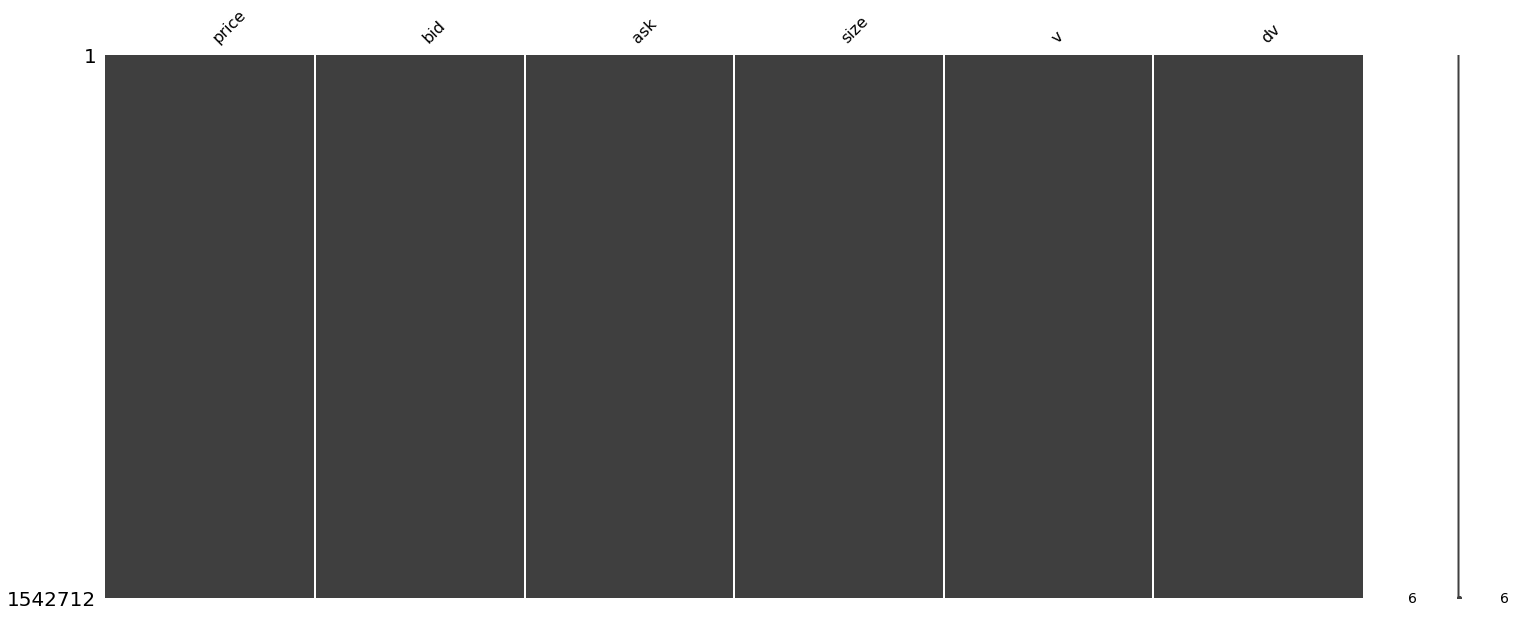

In [5]:
msno.matrix(df)

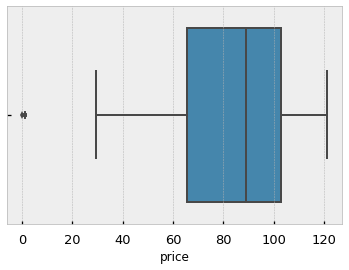

In [6]:
sns.boxplot(df.price)

In [7]:
@jit(nopython=True)
def mad_outlier(y, thresh=3.):
    '''
    compute outliers based on mad
    # args
        y: assumed to be array with shape (N,1)
        thresh: float()
    # returns
        array index of outliers
    '''
    median = np.median(y)
    diff = np.sum((y - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

In [8]:
mad = mad_outlier(df.price.values.reshape(-1,1))

In [9]:
df.loc[mad]

,price,bid,ask,size,v,dv
dates,,,,,,
2010-05-06 14:49:07,0.11,0.10,44.03,500,500,55.0
2010-05-06 14:53:30,1.10,1.10,30.28,2600,2600,2860.0
2010-05-06 14:55:32,1.10,1.10,50.57,300,300,330.0
2010-05-06 14:55:32,1.10,1.10,50.57,100,100,110.0
2010-05-06 14:55:32,1.10,1.00,50.57,200,200,220.0
2010-05-06 14:55:32,1.10,1.00,50.57,700,700,770.0
2010-05-06 14:55:32,1.10,1.00,50.57,1200,1200,1320.0
2010-05-06 14:55:32,1.10,0.55,50.57,500,500,550.0
2010-05-06 14:55:32,1.10,0.55,50.57,100,100,110.0


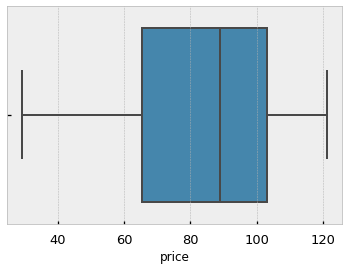

In [10]:
sns.boxplot(df.loc[~mad].price)

In [11]:
df = df.loc[~mad]
cprint(df)

outfp = PurePath('data//processed//clean_IVE_fut_prices.parq')
df.to_parquet(outfp)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                      price     bid     ask   size      v          dv
dates                                                                
2019-01-11 15:59:58  104.84  104.83  104.85    130    130    13629.20
2019-01-11 16:00:00  104.84  104.83  104.84  11407  11407  1195909.88
2019-01-11 16:10:00  104.84  104.78  105.04      0      0        0.00
2019-01-11 18:30:00  104.84  104.24  105.17      0      0        0.00
2019-01-11 20:00:00  104.84  104.46  105.06      0      0        0.00
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1542701 entries, 2009-09-28 09:30:00 to 2019-01-11 20:00:00
Data columns (total 6 columns):
price    1542701 non-null float64
bid      1542701 non-null float64
ask      1542701 non-null float64
size     1542701 non-null int6

In [12]:
infp=PurePath('data//processed//clean_IVE_fut_prices.parq')
df = pd.read_parquet(infp)
cprint(df)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                      price     bid     ask   size      v          dv
dates                                                                
2019-01-11 15:59:58  104.84  104.83  104.85    130    130    13629.20
2019-01-11 16:00:00  104.84  104.83  104.84  11407  11407  1195909.88
2019-01-11 16:10:00  104.84  104.78  105.04      0      0        0.00
2019-01-11 18:30:00  104.84  104.24  105.17      0      0        0.00
2019-01-11 20:00:00  104.84  104.46  105.06      0      0        0.00
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1542701 entries, 2009-09-28 09:30:00 to 2019-01-11 20:00:00
Data columns (total 6 columns):
price    1542701 non-null float64
bid      1542701 non-null float64
ask      1542701 non-null float64
size     1542701 non-null int6

In [13]:
def tick_bars(df, price_column, m):
    '''
    compute tick bars

    # args
        df: pd.DataFrame()
        column: name for price data
        m: int(), threshold value for ticks
    # returns
        idx: list of indices
    '''
    t = df[price_column]
    ts = 0
    idx = []
    for i, x in enumerate(tqdm(t)):
        ts += 1
        if ts >= m:
            idx.append(i)
            ts = 0
            continue
    return idx

def tick_bar_df(df, price_column, m):
    idx = tick_bars(df, price_column, m)
    return df.iloc[idx].drop_duplicates()

In [14]:
n_ticks = df.shape[0]
volume_ratio = (df.v.sum()/n_ticks).round()
dollar_ratio = (df.dv.sum()/n_ticks).round()
print(f'num ticks: {n_ticks:,}')
print(f'volume ratio: {volume_ratio}')
print(f'dollar ratio: {dollar_ratio}')

num ticks: 1,542,701
volume ratio: 549.0
dollar ratio: 47556.0


In [15]:
tick_M = 100 # arbitrary
print(f'tick threshold: {tick_M:,}')
tidx = tick_bars(df, 'price', tick_M)
tidx[:10]

 20%|██        | 311419/1542701 [00:00<00:00, 1247436.05it/s]

tick threshold: 100


100%|██████████| 1542701/1542701 [00:00<00:00, 2228821.72it/s]


[99, 199, 299, 399, 499, 599, 699, 799, 899, 999]

In [16]:
df.iloc[tidx].shape, df.shape

((15427, 6), (1542701, 6))

In [17]:
tick_df = tick_bar_df(df, 'price', tick_M)
tick_df.shape

100%|██████████| 1542701/1542701 [00:00<00:00, 2132395.88it/s]


(15427, 6)

In [18]:
def select_sample_data(ref, sub, price_col, date):
    '''
    select a sample of data based on date, assumes datetimeindex
    
    # args
        ref: pd.DataFrame containing all ticks
        sub: subordinated pd.DataFrame of prices
        price_col: str(), price column
        date: str(), date to select
    # returns
        xdf: ref pd.Series
        xtdf: subordinated pd.Series
    '''
    xdf = ref[price_col].loc[date]
    xtdf = sub[price_col].loc[date]
    return xdf, xtdf

## try different dates to see how the quantity of tick bars changes
xDate ='2009-10-01' #'2017-10-4'
xdf, xtdf = select_sample_data(df, tick_df, 'price', xDate)

xdf.shape, xtdf.shape

((1466,), (15,))

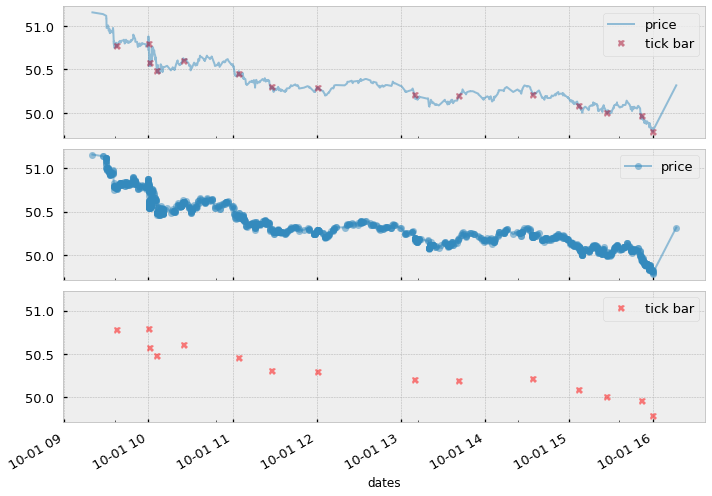

In [19]:
def plot_sample_data(ref, sub, bar_type, *args, **kwds):
    f,axes=plt.subplots(3,sharex=True, sharey=True, figsize=(10,7))
    ref.plot(*args, **kwds, ax=axes[0], label='price')
    sub.plot(*args, **kwds, ax=axes[0], marker='X', ls='', label=bar_type)
    axes[0].legend();
    
    ref.plot(*args, **kwds, ax=axes[1], label='price', marker='o')
    sub.plot(*args, **kwds, ax=axes[2], ls='', marker='X',
             color='r', label=bar_type)

    for ax in axes[1:]: ax.legend()
    plt.tight_layout()
    
    return

plot_sample_data(xdf, xtdf, 'tick bar', alpha=0.5, markersize=7)

In [20]:
def get_ohlc(ref, sub):
    '''
    fn: get ohlc from custom bars
    
    # args
        ref : reference pandas series with all prices
        sub : custom tick pandas series
    # returns
        tick_df : dataframe with ohlc values
    '''
    ohlc = []
    for i in tqdm(range(sub.index.shape[0]-1)):
        start,end = sub.index[i], sub.index[i+1]
        tmp_ref = ref.loc[start:end]
        max_px, min_px = tmp_ref.max(), tmp_ref.min()
        o,h,l,c = sub.iloc[i], max_px, min_px, sub.iloc[i+1]
        ohlc.append((end,start,o,h,l,c))
    cols = ['end','start','open','high','low','close']
    return (pd.DataFrame(ohlc,columns=cols))

In [22]:
sub = tick_df.price
ref = df.price 

tick_bars_ohlc = get_ohlc(ref, sub)
cprint(tick_bars_ohlc)

#outfp = PurePath(data_dir/'processed'/'tick_bars_ohlc.parq')
#tick_bars_ohlc.to_parquet(outfp)

100%|██████████| 15426/15426 [00:05<00:00, 2796.88it/s]

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                      end               start      open      high       low  \
15421 2019-01-11 13:45:21 2019-01-11 12:28:46  104.7200  104.9200  104.5502   
15422 2019-01-11 14:32:51 2019-01-11 13:45:21  104.6800  104.8006  104.6483   
15423 2019-01-11 15:25:50 2019-01-11 14:32:51  104.6900  104.7532  104.5845   
15424 2019-01-11 15:41:05 2019-01-11 15:25:50  104.6428  104.8179  104.6267   
15425 2019-01-11 18:30:00 2019-01-11 15:41:05  104.8074  104.8925  104.7643   

          close  
15421  104.6800  
15422  104.6900  
15423  104.6428  
15424  104.8074  
15425  104.8400  
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15426 entries, 0 to 15425
Data columns (total 6 columns):
end      15426 non-null datetime64[ns]
start    15426 non-null datetime64[ns

In [23]:
def volume_bars(df, volume_column, m):
    '''
    compute volume bars

    # args
        df: pd.DataFrame()
        volume_column: name for volume data
        m: int(), threshold value for volume
    # returns
        idx: list of indices
    '''
    t = df[volume_column]
    ts = 0
    idx = []
    for i, x in enumerate(tqdm(t)):
        ts += x
        if ts >= m:
            idx.append(i)
            ts = 0
            continue
    return idx

def volume_bar_df(df, volume_column, m):
    idx = volume_bars(df, volume_column, m)
    return df.iloc[idx].drop_duplicates()

In [25]:
volume_M =  10_000 # arbitrary 
print(f'volume threshold: {volume_M:,}')
v_bar_df = volume_bar_df(df, 'price', volume_M)
cprint(v_bar_df)

  5%|▍         | 73742/1542701 [00:00<00:01, 737418.95it/s]

volume threshold: 10,000


100%|██████████| 1542701/1542701 [00:00<00:00, 2043962.25it/s]

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                        price     bid     ask  size    v          dv
dates                                                               
2019-01-11 13:23:28  104.5801  104.58  104.61   250  250  26145.0250
2019-01-11 14:22:01  104.7400  104.73  104.74   800  800  83792.0000
2019-01-11 15:08:19  104.6934  104.68  104.70   134  134  14028.9156
2019-01-11 15:40:52  104.8110  104.81  104.82   110  110  11529.2100
2019-01-11 15:56:50  104.8300  104.83  104.84   179  179  18764.5700
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13155 entries, 2009-09-28 10:02:49 to 2019-01-11 15:56:50
Data columns (total 6 columns):
price    13155 non-null float64
bid      13155 non-null float64
ask      13155 non-null float64
size     13155 non-null int64
v        13155 

xdf shape: (1466,), xtdf shape: (7,)


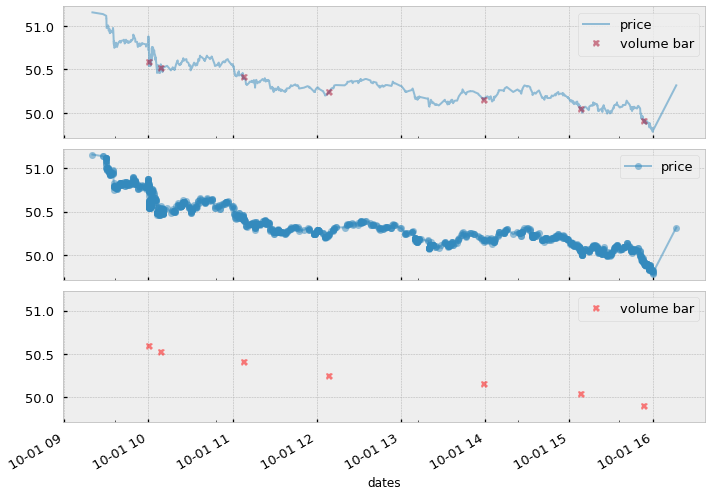

In [26]:
xDate = '2009-10-1'
xdf, xtdf = select_sample_data(df, v_bar_df, 'price', xDate)
print(f'xdf shape: {xdf.shape}, xtdf shape: {xtdf.shape}')

plot_sample_data(xdf, xtdf, 'volume bar', alpha=0.5, markersize=7)

In [29]:
def dollar_bars(df, dv_column, m):
    '''
    compute dollar bars

    # args
        df: pd.DataFrame()
        dv_column: name for dollar volume data
        m: int(), threshold value for dollars
    # returns
        idx: list of indices
    '''
    t = df[dv_column]
    ts = 0
    idx = []
    for i, x in enumerate(tqdm(t)):
        ts += x
        if ts >= m:
            idx.append(i)
            ts = 0
            continue
    return idx

def dollar_bar_df(df, dv_column, m):
    idx = dollar_bars(df, dv_column, m)
    return df.iloc[idx].drop_duplicates()

In [30]:
dollar_M = 1_000_000 # arbitrary 
print(f'dollar threshold: {dollar_M:,}')
dv_bar_df = dollar_bar_df(df, 'price', dollar_M)
cprint(dv_bar_df)

 18%|█▊        | 277474/1542701 [00:00<00:01, 1068763.73it/s]

dollar threshold: 1,000,000


100%|██████████| 1542701/1542701 [00:00<00:00, 2116106.00it/s]

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                        price     bid     ask  size    v          dv
dates                                                               
2018-12-21 12:42:23   99.4100   99.37   99.42   100  100   9941.0000
2018-12-26 14:22:21   97.2225   97.22   97.23   100  100   9722.2500
2018-12-28 11:44:32  100.6900  100.66  100.67   100  100  10069.0000
2019-01-03 13:53:19   99.7400   99.76   99.78   200  200  19948.0000
2019-01-10 15:01:55  104.5732  104.56  104.58   272  272  28443.9104
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 132 entries, 2009-10-30 11:11:12 to 2019-01-10 15:01:55
Data columns (total 6 columns):
price    132 non-null float64
bid      132 non-null float64
ask      132 non-null float64
size     132 non-null int64
v        132 non-null int

xdf shape: (488,), xtdf shape: (0,)


TypeError: Empty 'DataFrame': no numeric data to plot

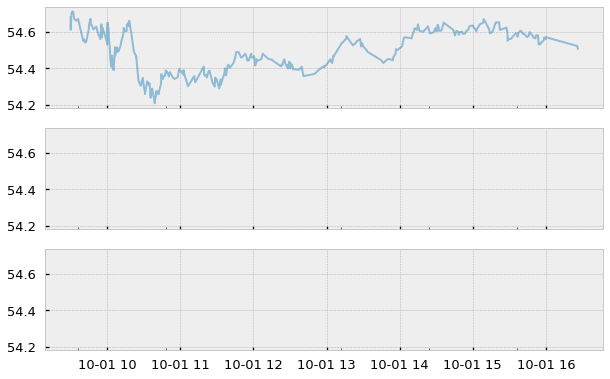

In [32]:
xDate = '2010-10-1'
xdf, xtdf = select_sample_data(df, dv_bar_df, 'price', xDate)
print(f'xdf shape: {xdf.shape}, xtdf shape: {xtdf.shape}')

plot_sample_data(xdf, xtdf, 'dollar bar', alpha=0.5, markersize=7) 